In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model
import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Input, Conv2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess_input
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.layers import Conv2D

from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.densenet import DenseNet169


print("TensorFlow Version:", tf.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


TensorFlow Version: 2.13.0


In [2]:
base_dir = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/"

root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'VeryMildDemented', 'NonDemented', 'ModerateDemented']


In [3]:
WORK_DIR = './dataset/'

CLASSES = [ 'MildDemented',
            'ModerateDemented',
            'NonDemented',
            'VeryMildDemented']

IMG_SIZE = 224
IMAGE_SIZE = [224,224]
DIM = (IMG_SIZE, IMG_SIZE)

In [4]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=train_dir, target_size=DIM, batch_size=6500, shuffle=False)


Found 5121 images belonging to 4 classes.


In [5]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

#Getting to know the dimensions of our dataset

print(train_data.shape, train_labels.shape)

(5121, 224, 224, 3) (5121, 4)


In [6]:
# Performing over-sampling of the data, since the classes are imbalanced
sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(10240, 224, 224, 3) (10240, 4)


In [7]:
#Splitting the data into train, test, and validation sets

train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)


In [8]:
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)

(8192, 224, 224, 3)
(8192, 4)
(2048, 224, 224, 3)
(2048, 4)


In [9]:
from sklearn.utils.class_weight import compute_sample_weight

# Assuming train_labels is your target variable
class_labels = np.unique(np.argmax(train_labels, axis=1))

# Compute class weights
class_weights = compute_sample_weight('balanced', train_labels.argmax(axis=1))

# Create a dictionary mapping class indices to their respective weights
class_weight_dict = dict(enumerate(class_weights))


In [10]:
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_dataset = test_datagen.flow_from_directory(
    directory= '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test',
    target_size=(224, 224),
    class_mode='categorical',  # or 'binary' depending on your use case
    batch_size=32,
    shuffle=False  # Ensure no shuffling
)
print(test_dataset.samples)

Found 1279 images belonging to 4 classes.
1279


In [11]:
from tensorflow.keras.models import Sequential


In [12]:
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D
model = Sequential()

model.add(Conv2D(32,kernel_size =(2,2),input_shape = (224, 224,3),padding = 'Same'))
model.add(Conv2D(32,kernel_size =(2,2),activation='relu',padding = 'Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,kernel_size =(2,2),activation='relu',padding = 'Same'))
model.add(Conv2D(64,kernel_size =(2,2),activation='relu',padding = 'Same'))

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides = (2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
          
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [13]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
]

# CALLBACKS = rop_callback

model.compile(optimizer='adam',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      416       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      4128      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      8

In [14]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 100

history = model.fit(train_data, train_labels,class_weight=class_weight_dict, validation_data=(val_data, val_labels), epochs=EPOCHS)

Epoch 1/100


2024-05-07 04:17:59.252946: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


256/256 [==============================] - 56s 194ms/step - loss: 11.9746 - accuracy: 0.7387 - precision: 0.3146 - recall: 0.0382 - auc: 0.5072 - val_loss: 74.0624 - val_accuracy: 0.6572 - val_precision: 0.3145 - val_recall: 0.3145 - val_auc: 0.5432
Epoch 2/100
256/256 [==============================] - 48s 187ms/step - loss: 1.3854 - accuracy: 0.7503 - precision: 0.7368 - recall: 0.0017 - auc: 0.5011 - val_loss: 2.0042 - val_accuracy: 0.7421 - val_precision: 0.3852 - val_recall: 0.0532 - val_auc: 0.5395
Epoch 3/100
256/256 [==============================] - 48s 188ms/step - loss: 1.3869 - accuracy: 0.7500 - precision: 0.5714 - recall: 4.8828e-04 - auc: 0.4945 - val_loss: 1.4333 - val_accuracy: 0.7511 - val_precision: 0.6364 - val_recall: 0.0103 - val_auc: 0.5035
Epoch 4/100
256/256 [==============================] - 48s 188ms/step - loss: 1.3860 - accuracy: 0.7501 - precision: 1.0000 - recall: 2.4414e-04 - auc: 0.5009 - val_loss: 1.4134 - val_accuracy: 0.7495 - val_precision: 0.4000 -

In [15]:
# Evaluate the model on the test set
test_scores = model.evaluate(test_dataset)
print("Test Loss:", test_scores[0])
print("Test Accuracy:", test_scores[1])

40/40 [==============================] - 4s 101ms/step - loss: 1.3865 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4266
Test Loss: 1.3864917755126953
Test Accuracy: 0.75


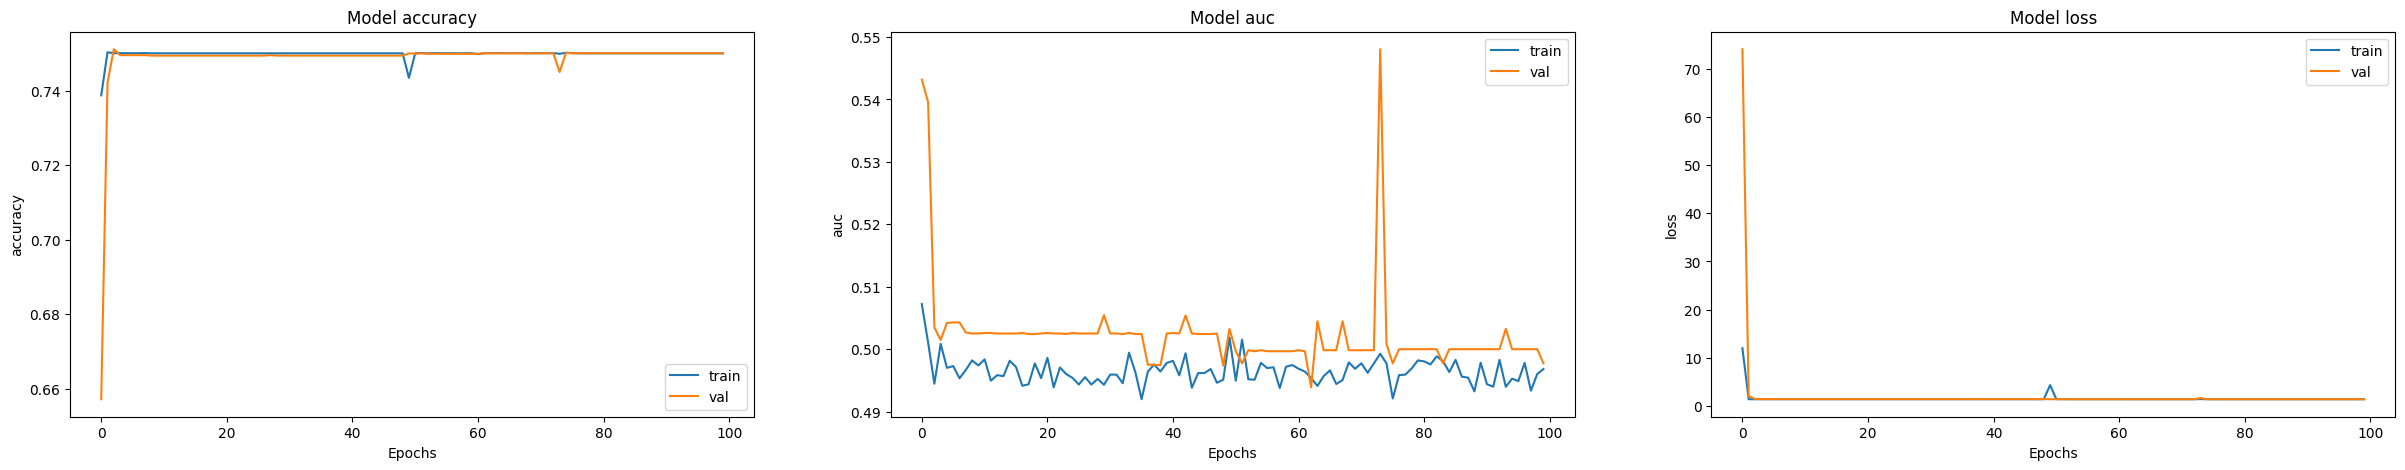

In [16]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["accuracy", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [17]:
pred_labels = model.predict(test_dataset)

def roundoff(arr):
    """To round off according to the argmax of each predicted label array."""
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)
    
pred = np.argmax(pred_labels,axis=1)

print(classification_report(test_dataset.classes,pred))

40/40 [==============================] - 2s 54ms/step
              precision    recall  f1-score   support

           0       0.14      1.00      0.25       179
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00       640
           3       0.00      0.00      0.00       448

    accuracy                           0.14      1279
   macro avg       0.03      0.25      0.06      1279
weighted avg       0.02      0.14      0.03      1279



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
test_labels = test_dataset.classes

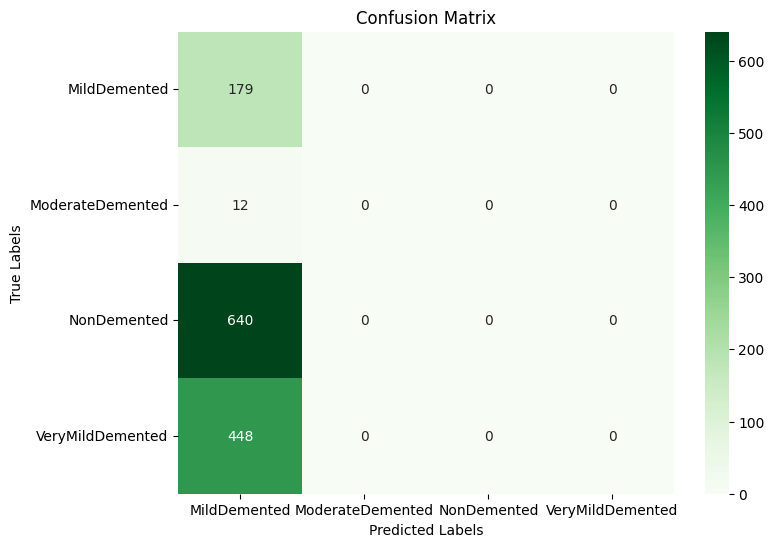

In [19]:
import numpy as npm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming test_labels are integer labels
one_hot_test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=4)

# Get the predicted class labels from the one-hot encoded format
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(one_hot_test_labels, axis=1)

# Compute the confusion matrix
conf_arr = confusion_matrix(test_ls, pred_ls)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [20]:
import os
from shutil import copyfile, rmtree
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from keras.applications import MobileNetV2
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, BatchNormalization
import tensorflow as tf
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Specify the base directory for the dataset
base_dir = "/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset"

# Specify the selected classes
selected_classes = [ 'MildDemented','ModerateDemented']

# Create a new working directory for the selected classes
work_dir_selected = root_dir + "dataset_selected/"
if os.path.exists(work_dir_selected):
    rmtree(work_dir_selected)

os.mkdir(work_dir_selected)

# Copy only the selected classes to the new working directory
for class_name in selected_classes:
    source_dir_train = os.path.join(base_dir, 'train', class_name)
    dest_dir_train = os.path.join(work_dir_selected, 'train', class_name)
    os.makedirs(dest_dir_train, exist_ok=True)
    for file_name in os.listdir(source_dir_train):
        copyfile(os.path.join(source_dir_train, file_name), os.path.join(dest_dir_train, file_name))

    source_dir_test = os.path.join(base_dir, 'test', class_name)
    dest_dir_test = os.path.join(work_dir_selected, 'test', class_name)
    os.makedirs(dest_dir_test, exist_ok=True)
    for file_name in os.listdir(source_dir_test):
        copyfile(os.path.join(source_dir_test, file_name), os.path.join(dest_dir_test, file_name))

# Print the contents of the new working directory
print("Working Directory Contents (Selected Classes):", os.listdir(work_dir_selected))

# Set up data generators for the selected classes
work_dr_selected = IDG(rescale=1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen_selected = work_dr_selected.flow_from_directory(
    directory=os.path.join(work_dir_selected, 'train'),
    target_size=DIM,
    batch_size=6500,  # Set a sufficiently large batch size
    shuffle=False
)



Working Directory Contents (Selected Classes): ['test', 'train']
Found 769 images belonging to 2 classes.


In [21]:
# Retrieve the data for the selected classes
train_data_selected, train_labels_selected = train_data_gen_selected.next()

In [22]:
# Shuffle the data to avoid bias
train_data_selected, train_labels_selected = shuffle(train_data_selected, train_labels_selected)

# Split the data into train and validation sets
train_data_selected, val_data_selected, train_labels_selected, val_labels_selected = train_test_split(
    train_data_selected, train_labels_selected, test_size=0.2, random_state=42
)


In [27]:
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D
model2 = Sequential()

model2.add(Conv2D(32,kernel_size =(2,2),input_shape = (224, 224,3),padding = 'Same'))
model2.add(Conv2D(32,kernel_size =(2,2),activation='relu',padding = 'Same'))

model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64,kernel_size =(2,2),activation='relu',padding = 'Same'))
model2.add(Conv2D(64,kernel_size =(2,2),activation='relu',padding = 'Same'))

model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2),strides = (2,2)))
model2.add(Dropout(0.25))
model2.add(Flatten())
          
model2.add(Dense(512,activation = 'relu'))
model2.add(Dropout(0.5))
model2.add(Dense(2,activation='softmax'))

In [28]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
]

# CALLBACKS = rop_callback

model2.compile(optimizer='adam',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      416       
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 32)      4128      
                                                                 
 batch_normalization_4 (Bat  (None, 224, 224, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 64)     

In [29]:
# Train the model on the selected classes
EPOCHS_SELECTED = 100

history_selected = model2.fit(
    train_data_selected, train_labels_selected,class_weight=class_weight_dict,
    validation_data=(val_data_selected, val_labels_selected),
    epochs=EPOCHS_SELECTED
)

Epoch 1/100


2024-05-07 05:42:13.180933: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


20/20 [==============================] - 8s 278ms/step - loss: 23.6814 - accuracy: 0.8732 - precision: 0.8732 - recall: 0.8732 - auc: 0.8863 - val_loss: 0.5107 - val_accuracy: 0.9156 - val_precision: 0.9156 - val_recall: 0.9156 - val_auc: 0.9134
Epoch 2/100
20/20 [==============================] - 4s 192ms/step - loss: 4.6679 - accuracy: 0.8959 - precision: 0.8959 - recall: 0.8959 - auc: 0.9114 - val_loss: 0.4082 - val_accuracy: 0.9091 - val_precision: 0.9091 - val_recall: 0.9091 - val_auc: 0.9585
Epoch 3/100
20/20 [==============================] - 4s 192ms/step - loss: 0.4607 - accuracy: 0.9236 - precision: 0.9236 - recall: 0.9236 - auc: 0.9389 - val_loss: 1.0617 - val_accuracy: 0.8052 - val_precision: 0.8052 - val_recall: 0.8052 - val_auc: 0.7417
Epoch 4/100
20/20 [==============================] - 4s 191ms/step - loss: 0.3119 - accuracy: 0.9252 - precision: 0.9252 - recall: 0.9252 - auc: 0.9455 - val_loss: 4.3044 - val_accuracy: 0.5390 - val_precision: 0.5390 - val_recall: 0.5390 -

In [30]:
# Evaluate the selected model on the test set containing only 'NonDemented' and 'VeryMildDemented' classes
test_dataset_selected = work_dr_selected.flow_from_directory(
    directory=os.path.join(work_dir_selected, 'test'),
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 191 images belonging to 2 classes.


In [31]:
test_scores_selected = model2.evaluate(test_dataset_selected)

print("Test Loss (Selected Classes):", test_scores_selected[0])
print("Test Accuracy (Selected Classes):", test_scores_selected[1])


6/6 [==============================] - 3s 363ms/step - loss: 0.6528 - accuracy: 0.9372 - precision: 0.9372 - recall: 0.9372 - auc: 0.9568
Test Loss (Selected Classes): 0.6527738571166992
Test Accuracy (Selected Classes): 0.9371727705001831


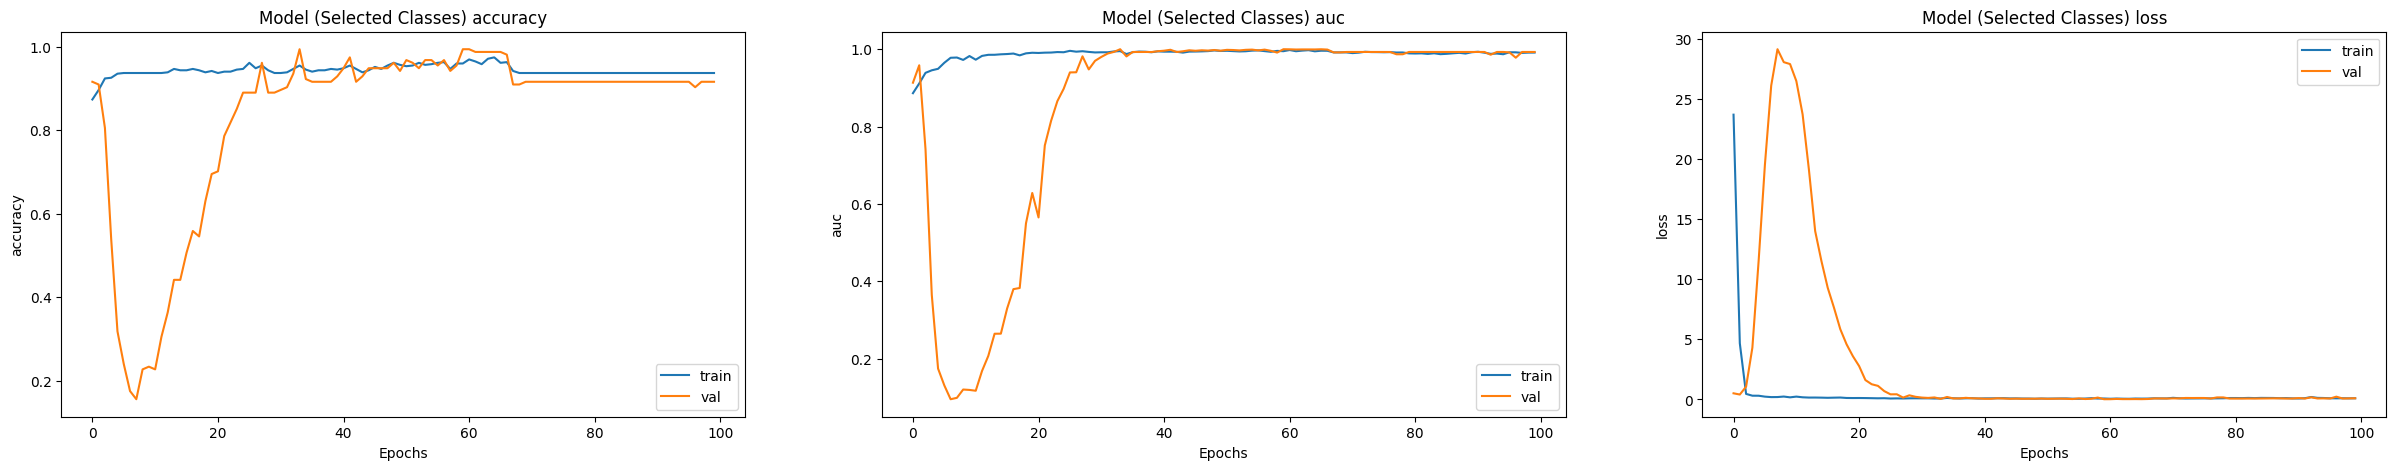

In [32]:
# Plot the trend of the metrics during training for the selected model
fig_selected, ax_selected = plt.subplots(1, 3, figsize=(30, 5))
ax_selected = ax_selected.ravel()

for i, metric in enumerate(["accuracy", "auc", "loss"]):
    ax_selected[i].plot(history_selected.history[metric])
    ax_selected[i].plot(history_selected.history["val_" + metric])
    ax_selected[i].set_title("Model (Selected Classes) {}".format(metric))
    ax_selected[i].set_xlabel("Epochs")
    ax_selected[i].set_ylabel(metric)
    ax_selected[i].legend(["train", "val"])

In [33]:
# Predict labels for the test set containing only 'NonDemented' and 'VeryMildDemented' classes
pred_labels_selected = model2.predict(test_dataset_selected)

# Round off predictions
for labels in pred_labels_selected:
    labels = roundoff(labels)

# Convert predictions to class indices
pred_selected = np.argmax(pred_labels_selected, axis=1)

# Print classification report for the selected classes
print(classification_report(test_dataset_selected.classes, pred_selected))

6/6 [==============================] - 2s 367ms/step
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       179
           1       0.00      0.00      0.00        12

    accuracy                           0.94       191
   macro avg       0.47      0.50      0.48       191
weighted avg       0.88      0.94      0.91       191



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


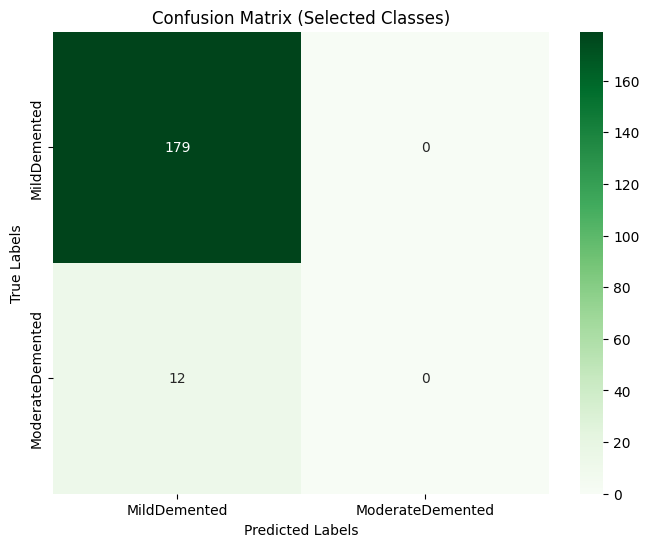

In [34]:
# Compute and plot the confusion matrix for the selected classes
one_hot_test_labels_selected = tf.keras.utils.to_categorical(test_dataset_selected.classes, num_classes=len(selected_classes))
conf_arr_selected = confusion_matrix(np.argmax(one_hot_test_labels_selected, axis=1), pred_selected)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_arr_selected, cmap='Greens', annot=True, fmt='d', xticklabels=selected_classes, yticklabels=selected_classes)

plt.title('Confusion Matrix (Selected Classes)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
